### ISyE524: Intro to Optimization
#### Problem Set #3
##### 1. MaxFlow
###### 1-1


\begin{align*}
\text{Max} \quad & x_{ts} \\
\text{Subject to:} \quad & \sum_{j \in N} x_{ij} - \sum_{j \in N} x_{ji} = 0 \quad \forall i \in N \\
& 0 \leq x_{ij} \leq u_{ij} \quad \forall (i, j) \in A 
\end{align*}

###### 1-2

\begin{align*}
\text{Min} \quad & \sum_{(i,j) \in A} \mu_{ij} \lambda_{ij} \\
\text{Subject to:} \quad & \mu_{i} - \mu_{j} + \lambda_{ij} \geq 0 \quad \forall (i,j) \in A \\
& -\mu_{s} + \mu_{t} \geq 1\\
& \mu_{i}   free \quad \forall i \in N \\
& 0 \leq \lambda_{ij} \quad \forall (i, j) \in A 
\end{align*}

###### 1-3

In [3]:
using JuMP, GLPK

# Define the model using the GLPK solver
model = Model(GLPK.Optimizer)

# Define the edges of the network and their capacities
edges = Dict(('s', '1') => 6, ('s', '2') => 2, ('1', '3') => 3, 
             ('2', '1') => 1, ('2', '4') => 7, ('3', 't') => 2,
             ('4', '3') => 3, ('4', 't') => 7, ('t', 's') => Inf)

# Define the flow variables for each edge
@variable(model, f[edges.keys()] >= 0)

# Capacity constraints
for edge in keys(edges)
    @constraint(model, f[edge] <= edges[edge])
end

# Flow conservation constraints, except for s and t
nodes = ['1', '2', '3', '4']
for node in nodes
    inflow = sum(f[i, node] for i in nodes if (i, node) in keys(f))
    outflow = sum(f[node, j] for j in nodes if (node, j) in keys(f))
    @constraint(model, inflow == outflow)
end

# Add the circulation arc constraint
@constraint(model, f['t', 's'] - f['s', 't'] == 0)

# Objective: maximize flow out of s minus flow into s (which should be zero)
out_of_s = sum(f['s', j] for j in nodes if ('s', j) in keys(f))
@objective(model, Max, out_of_s)

# Solve the optimization problem
optimize!(model)

# Output the optimal flow value and the flows on each edge
println("Maximum flow from s to t: ", objective_value(model))
for edge in keys(edges)
    println("Flow on edge ", edge, ": ", value(f[edge]))
end


MethodError: MethodError: objects of type Vector{Tuple{Char, Char}} are not callable
Use square brackets [] for indexing an Array.

###### 1-4

###### 1-5

##### 2. Lasso
###### 2-1

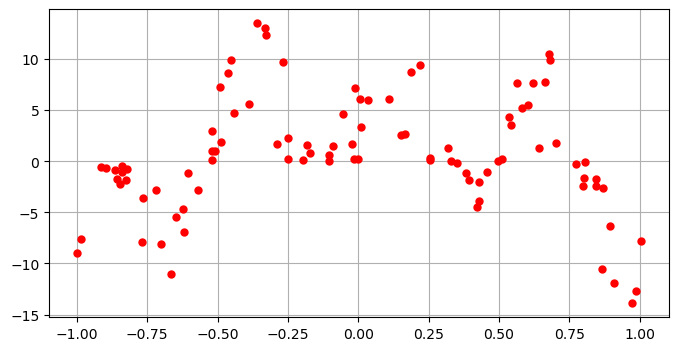

In [4]:
using PyPlot, CSV, DataFrames

data = CSV.read("lasso-data.csv", DataFrame)
x = data[:,1]
y = data[:,2]

cla()
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
grid("True")
# Only need this in vscode?
display(gcf())

In [12]:
# Fit the data using a function of the form y = f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

# Order of polynomial used for fitting
k = 6

# Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end
A

94×7 Matrix{Float64}:
 0.91686   -0.93022   0.943775  -0.957528  0.971481  -0.985637  1.0
 0.991306  -0.99275   0.994196  -0.995644  0.997094  -0.998546  1.0
 0.578547  -0.633795  0.694319  -0.760623  0.833258  -0.91283   1.0
 0.415913  -0.481396  0.557188  -0.644914  0.74645   -0.863974  1.0
 0.368498  -0.435207  0.513993  -0.607041  0.716933  -0.846719  1.0
 0.351794  -0.418704  0.49834   -0.593123  0.705932  -0.840198  1.0
 0.312462  -0.379313  0.460466  -0.558983  0.678577  -0.823758  1.0
 0.524983  -0.584504  0.650774  -0.724557  0.806706  -0.898168  1.0
 0.397282  -0.463357  0.540422  -0.630303  0.735134  -0.857399  1.0
 0.351542  -0.418454  0.498102  -0.59291   0.705763  -0.840097  1.0
 ⋮                                                    ⋮         
 0.42255    0.487788  0.5631     0.650038  0.7504     0.866256  1.0
 0.359675   0.426506  0.505755   0.599729  0.711165   0.843306  1.0
 0.515851   0.576019  0.643205   0.718227  0.802001   0.895545  1.0
 0.436541   0.501211  0.57546

In [13]:
# Solve the LEAST SQUARES polynomial fit

using JuMP, HiGHS
m6 = Model(HiGHS.Optimizer)

@variable(m6, u[1:k+1])
@objective(m6, Min, sum( (y - A*u).^2 ) )

optimize!(m6)
uopt6 = value.(u)
println(termination_status(m6))
println("The error is ", objective_value(m6))
println("The coefficients are ", uopt6)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.000400, 3073.967606, 7
3, 0.000505, 1607.360992, 7
Model   status      : Optimal
Objective value     :  1.6073609922e+03
HiGHS run time      :          0.00
OPTIMAL
The error is 1607.3609921595705
The coefficients are [-2.249371900396229, -41.30577606533521, -8.493550837855988, 43.82460620435696, -1.8469776466959757, -8.539113160802808, 3.375813786151018]


###### 2-2

In [14]:
# Fit the data using a function of the form y = f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

# Order of polynomial used for fitting
k = 18

# Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end
A

94×19 Matrix{Float64}:
 0.770742   -0.781973   0.793368   …  -0.957528  0.971481  -0.985637  1.0
 0.974145   -0.975563   0.976984      -0.995644  0.997094  -0.998546  1.0
 0.193649   -0.212142   0.2324        -0.760623  0.833258  -0.91283   1.0
 0.0719464  -0.0832738  0.0963847     -0.644914  0.74645   -0.863974  1.0
 0.0500388  -0.0590972  0.0697956     -0.607041  0.716933  -0.846719  1.0
 0.0435379  -0.0518186  0.0616743  …  -0.593123  0.705932  -0.840198  1.0
 0.0305064  -0.0370332  0.0449565     -0.558983  0.678577  -0.823758  1.0
 0.144689   -0.161093   0.179358      -0.724557  0.806706  -0.898168  1.0
 0.0627044  -0.0731332  0.0852965     -0.630303  0.735134  -0.857399  1.0
 0.0434442  -0.0517133  0.0615564     -0.59291   0.705763  -0.840097  1.0
 ⋮                                 ⋱   ⋮                              
 0.0754455   0.0870938  0.10054    …   0.650038  0.7504     0.866256  1.0
 0.0465298   0.0551755  0.0654276      0.599729  0.711165   0.843306  1.0
 0.137269    0.153

In [15]:
# Solve the LEAST SQUARES polynomial fit

using JuMP, HiGHS
m18 = Model(HiGHS.Optimizer)

@variable(m18, u[1:k+1])
@objective(m18, Min, sum( (y - A*u).^2 ) )

optimize!(m18)
uopt18 = value.(u)
println(termination_status(m18))
println("The error is ", objective_value(m18))
println("The coefficients are ", uopt18)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.000452, 3073.967606, 19
3, 0.000733, 522.039311, 19
Model   status      : Optimal
Objective value     :  5.2203999098e+02
HiGHS run time      :          0.00
OPTIMAL
The error is 522.0399909810724
The coefficients are [-85777.96987569737, -34190.35284858116, 391618.11446229444, 145410.400856986, -743933.078416506, -248442.9827777201, 761790.0455611285, 214415.78339220045, -455126.1937070716, -93662.63157967123, 160101.09152807322, 15385.569783950783, -31648.88748634598, 1765.1586151727297, 3070.4161891439185, -713.8251991827888, -106.44740057256564, 33.180843520283986, 3.92627202618853]


###### 2-3

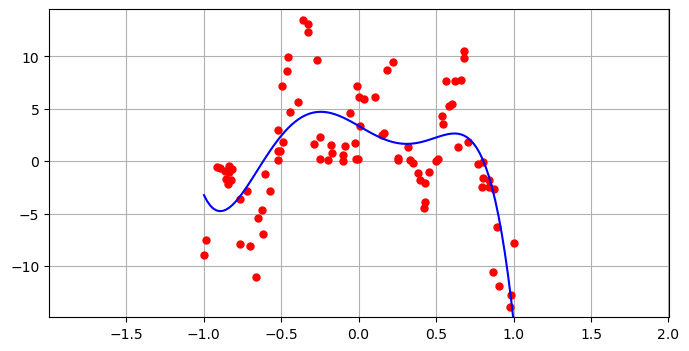

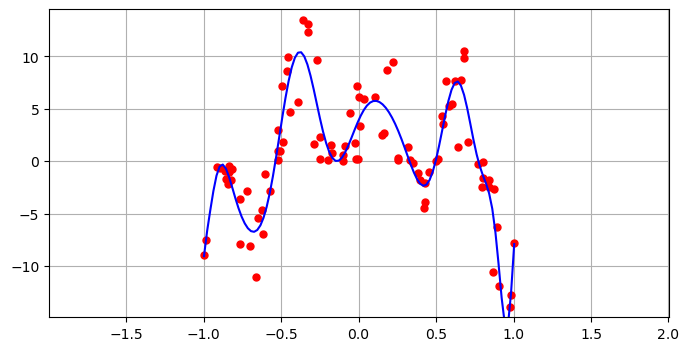

In [17]:
using PyPlot, LinearAlgebra
function plotwregsol(x,y,usol)

    minx = minimum(x)
    maxx = maximum(x)
    miny = minimum(y)
    maxy = maximum(y)   

    # Make (npts,k+1) matrix containing polynomial term values at plot points.  Fancy matrix stuff.
    npts = 100
    xfine = range(minx,stop=maxx,length=npts)
    ffine = ones(npts)
    for j = 1:k
        ffine = [ffine.*xfine ones(npts)]
    end

    # Compute the estimate values
    yfine = ffine * usol

    # Plot 'em
    figure(figsize=(8,4))
    plot(x,y,"r.", markersize=10)
    plot( xfine, yfine, "b-")

    axis([minx-1,maxx+1,miny-1,maxy+1])

    grid()
    display(gcf())
end
k = 6
plotwregsol(x,y,uopt6)
k = 18
plotwregsol(x,y,uopt18)

###### 2-4

##### 3. Beam Me Up
###### 3-1

###### 3-2

###### 3-3

##### 4. Nonconvex QP
###### 4-1

###### 4-2

###### 4-3

###### 4-4

##### 5. Pod Racing Rendezvous
###### 5-1

###### 5-2

###### 5-3

###### 5-4

###### 5-5